### Description
ABC Bank has recently experienced an increase in fraudulent online transactions. The bank
is seeking to implement a more robust fraud detection system to mitigate financial losses and
protect its customers. They have collected a dataset of online transactions containing both
legitimate and fraudulent transactions. The dataset is split into three separate tables: customers,
transactions, and merchants.

### Objective
Build a predictive model to identify potentially fraudulent transactions.
Provide recommendations to FinTech Bank on how to improve their fraud detection system based on your findings.

### Dataset Overview
The dataset is split into three tables:
- **Customers table:** Contains customer_id, account_age and customer_demographics.
- **Transactions table:** Records of online transactions including transaction_id, customer_id, transaction_timestamp, transaction_amount, transaction_type, payment_method, account_balance_before, account_balance_after, transaction_device, ip_address, user_agent, and is_fraud.
- **Merchants table:** Information about the merchants involved merchan_id, merchan_category.

In [1]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

# Import required libraries
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from copy import deepcopy

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, average_precision_score, ConfusionMatrixDisplay

/var/folders/rs/npbl7mfn541_qpccznbt37jr0000gn/T/ipykernel_18503/3277580516.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Purpose: Analyze input Pandas DataFrame and return stats per column
# Details: The function calculates levels for categorical variables and allows to analyze summarized information
    
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [3]:
# Load datasets
customers_df = pd.read_csv('ds_customers.csv')
transactions_df = pd.read_csv('ds_transactions.csv')
merchants_df = pd.read_csv('ds_merchants.csv')

In [4]:
print("Dataset Information:")
print("Customers Shape:", customers_df.shape)
print("Transactions Shape:", transactions_df.shape)
print("Merchants Shape:", merchants_df.shape)

Dataset Information:
Customers Shape: (2499, 3)
Transactions Shape: (1000000, 13)
Merchants Shape: (249, 2)


In [5]:
pd.options.display.max_colwidth = 150
desc_df = describe_more(customers_df)
desc_df

,A_Variable,Levels,Datatype,Level_Values
0,customer_id,2499,int64,"{1: 1, 1670: 1, 1663: 1, 1664: 1, 1665: 1, 1666: 1, 1667: 1, 1668: 1, 1669: 1, 1671: 1, 1661: 1, 1672: 1, 1673: 1, 1674: 1, 1675: 1, 1676: 1, 1677..."
1,account_age,1406,int64,"{1920: 6, 1021: 5, 1595: 5, 615: 5, 1838: 5, 1065: 5, 88: 5, 1458: 5, 1846: 5, 1664: 5, 267: 5, 1782: 5, 978: 5, 251: 5, 234: 5, 1608: 5, 1754: 4,..."
2,customer_demographics,5,object,"{'{'sex': 'M', 'address': '0983 Jeffrey Mill\nKathyport, MD 22227', 'birthdate': '1971-03-24'}': 1, '{'sex': 'F', 'address': 'Unit 5895 Box 0684\n..."


In [6]:
pd.options.display.max_colwidth = 150
desc_df = describe_more(transactions_df)
desc_df

,A_Variable,Levels,Datatype,Level_Values
0,transaction_id,1000000,int64,"{1: 1, 666658: 1, 666660: 1, 666661: 1, 666662: 1, 666663: 1, 666664: 1, 666665: 1, 666666: 1, 666667: 1, 666668: 1, 666669: 1, 666670: 1, 666671:..."
1,customer_id,2500,int64,"{2192: 466, 2315: 465, 2483: 465, 1312: 463, 199: 462, 2169: 459, 2009: 457, 450: 455, 149: 455, 59: 454, 1090: 454, 1347: 453, 1966: 453, 845: 45..."
2,transaction_timestamp,731,object,"{'3/31/23': 1493, '11/29/22': 1487, '5/12/22': 1466, '8/27/21': 1457, '10/12/22': 1457, '3/28/22': 1456, '12/6/21': 1456, '5/22/22': 1450, '8/21/2..."
3,transaction_amount,634836,float64,"{1427.13: 9, 4160.32: 8, 4279.89: 8, 2987.6: 8, 2976.09: 8, 1942.12: 8, 7550.8: 8, 6117.68: 8, 4542.33: 8, 2375.82: 7, 1632.75: 7, 2294.74: 7, 985..."
4,transaction_type,8,object,"{'transfer': 249856, 'withdrawal': 249261, 'purchase': 248751, 'deposit': 248352, 'TRANSFER': 985, 'PURCHASE': 957, 'WITHDRAWAL': 930, 'DEPOSIT': ..."
5,payment_method,6,object,"{'bank transfer': 332282, 'credit card': 332017, 'debit card': 331910, 'BANK TRANSFER': 1300, 'CREDIT CARD': 1255, 'DEBIT CARD': 1236}"
6,account_balance_before,787735,float64,"{4108.53: 6, 7496.83: 6, 3003.03: 6, 13726.96: 6, 12205.68: 6, 2327.6: 6, 18709.1: 6, 11.0: 6, 9223.83: 6, 11324.72: 6, 3665.24: 6, 11685.07: 6, 1..."
7,account_balance_after,853074,float64,"{11887.7: 7, 8700.35: 6, 11124.52: 6, 9201.25: 6, 1665.26: 6, 5114.68: 6, 10008.07: 5, 4212.11: 5, 14508.34: 5, 9089.93: 5, 6707.67: 5, 10430.05: ..."
8,transaction_device,6,object,"{'desktop': 332178, 'mobile': 332090, 'tablet': 331900, 'MOBILE': 1299, 'TABLET': 1274, 'DESKTOP': 1259}"
9,ip_address,999849,object,"{'84.148.220.204': 2, '73.17.169.243': 2, '146.196.43.232': 2, '48.85.82.132': 2, '158.53.201.152': 2, '58.163.117.104': 2, '185.213.133.162': 2, ..."


In [7]:
pd.options.display.max_colwidth = 150
desc_df = describe_more(merchants_df)
desc_df

,A_Variable,Levels,Datatype,Level_Values
0,merchant_id,249,int64,"{1: 1, 172: 1, 159: 1, 160: 1, 161: 1, 162: 1, 163: 1, 164: 1, 165: 1, 166: 1, 167: 1, 168: 1, 169: 1, 170: 1, 171: 1, 173: 1, 126: 1, 174: 1, 175..."
1,merchant_category,6,object,"{'grocery': 52, 'clothing': 44, 'entertainment': 42, 'electronics': 40, 'travel': 38, 'health': 33}"


---

### Data Preparation

In [8]:
df_merged = transactions_df.merge(customers_df, on='customer_id', how='left')
df_merged = df_merged.merge(merchants_df, on='merchant_id', how='left')

In [9]:
# Covert column values to lowercase
df_merged['transaction_type'] = df_merged['transaction_type'].str.lower()
df_merged['payment_method'] = df_merged['payment_method'].str.lower()
df_merged['transaction_device'] = df_merged['transaction_device'].str.lower()

In [10]:
pd.options.display.max_colwidth = 150
desc_df = describe_more(df_merged)
desc_df

,A_Variable,Levels,Datatype,Level_Values
0,transaction_id,1000000,int64,"{1: 1, 666658: 1, 666660: 1, 666661: 1, 666662: 1, 666663: 1, 666664: 1, 666665: 1, 666666: 1, 666667: 1, 666668: 1, 666669: 1, 666670: 1, 666671:..."
1,customer_id,2500,int64,"{2192: 466, 2315: 465, 2483: 465, 1312: 463, 199: 462, 2169: 459, 2009: 457, 450: 455, 149: 455, 59: 454, 1090: 454, 1347: 453, 1966: 453, 845: 45..."
2,transaction_timestamp,731,object,"{'3/31/23': 1493, '11/29/22': 1487, '5/12/22': 1466, '8/27/21': 1457, '10/12/22': 1457, '3/28/22': 1456, '12/6/21': 1456, '5/22/22': 1450, '8/21/2..."
3,transaction_amount,634836,float64,"{1427.13: 9, 4160.32: 8, 4279.89: 8, 2987.6: 8, 2976.09: 8, 1942.12: 8, 7550.8: 8, 6117.68: 8, 4542.33: 8, 2375.82: 7, 1632.75: 7, 2294.74: 7, 985..."
4,transaction_type,4,object,"{'transfer': 250841, 'withdrawal': 250191, 'purchase': 249708, 'deposit': 249260}"
5,payment_method,3,object,"{'bank transfer': 333582, 'credit card': 333272, 'debit card': 333146}"
6,account_balance_before,787735,float64,"{4108.53: 6, 7496.83: 6, 3003.03: 6, 13726.96: 6, 12205.68: 6, 2327.6: 6, 18709.1: 6, 11.0: 6, 9223.83: 6, 11324.72: 6, 3665.24: 6, 11685.07: 6, 1..."
7,account_balance_after,853074,float64,"{11887.7: 7, 8700.35: 6, 11124.52: 6, 9201.25: 6, 1665.26: 6, 5114.68: 6, 10008.07: 5, 4212.11: 5, 14508.34: 5, 9089.93: 5, 6707.67: 5, 10430.05: ..."
8,transaction_device,3,object,"{'desktop': 333437, 'mobile': 333389, 'tablet': 333174}"
9,ip_address,999849,object,"{'84.148.220.204': 2, '73.17.169.243': 2, '146.196.43.232': 2, '48.85.82.132': 2, '158.53.201.152': 2, '58.163.117.104': 2, '185.213.133.162': 2, ..."


In [11]:
df_merged.describe(include='O').T

,count,unique,top,freq
transaction_timestamp,996238,731,3/31/23,1493
transaction_type,1000000,4,transfer,250841
payment_method,1000000,3,bank transfer,333582
transaction_device,1000000,3,desktop,333437
ip_address,1000000,999849,84.148.220.204,2
user_agent,1000000,750757,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 10.0; Trident/5.0),580
customer_demographics,1876,5,"{'sex': 'F', 'address': 'Unit 5895 Box 0684\nDPO AE 99907', 'birthdate': '1952-02-25'}",392
merchant_category,248754,6,grocery,51875


In [12]:
# Duplicated and null values
print("Duplicate Values:")
print(df_merged.duplicated().sum())
    
print("\nMissing Values:")
print(df_merged.isnull().sum())

Duplicate Values:
0

Missing Values:
transaction_id                 0
customer_id                    0
transaction_timestamp       3762
transaction_amount             0
transaction_type               0
payment_method                 0
account_balance_before         0
account_balance_after          0
transaction_device             0
ip_address                     0
user_agent                     0
is_fraud                       0
merchant_id               750292
account_age                  387
customer_demographics     998124
merchant_category         751246
dtype: int64


In [13]:
df_merged = df_merged.drop(columns=['merchant_id', 'customer_demographics'], axis=1)

In [14]:
# Handling missing values in Transaction Timestamp
# Datatype
df_merged['transaction_timestamp'] = pd.to_datetime(df_merged['transaction_timestamp'])

# Forward Fill
df_merged['transaction_timestamp'] = df_merged.groupby('customer_id')['transaction_timestamp'].ffill()

# Mean imputation
mean_date = df_merged['transaction_timestamp'].mean()
df_merged['transaction_timestamp'].fillna(mean_date, inplace=True)

In [15]:
# Handling missing values in Account Age
# Mean imputation
mean_age = df_merged['account_age'].mean()
df_merged['account_age'].fillna(mean_age, inplace=True)

In [16]:
# Handling missing values in Merchant Category
# Backward Fill
df_merged['merchant_category'] = df_merged.groupby('customer_id')['merchant_category'].bfill()

# Mode imputation
mode_category = df_merged['merchant_category'].mode()
df_merged['merchant_category'].fillna(mode_category, inplace=True)

In [17]:
print("\nMissing Values:")
print(df_merged.isnull().sum())


Missing Values:
transaction_id               0
customer_id                  0
transaction_timestamp        0
transaction_amount           0
transaction_type             0
payment_method               0
account_balance_before       0
account_balance_after        0
transaction_device           0
ip_address                   0
user_agent                   0
is_fraud                     0
account_age                  0
merchant_category         7485
dtype: int64


In [18]:
# Print the first few rows of the dataset
df_merged.head()

,transaction_id,customer_id,transaction_timestamp,transaction_amount,transaction_type,payment_method,account_balance_before,account_balance_after,transaction_device,ip_address,user_agent,is_fraud,account_age,merchant_category
0,1,115,2022-12-21,392.44,transfer,debit card,7032.36,7424.80,tablet,7.53.209.71,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.0; Trident/4.0),1,668.0,grocery
1,2,2395,2021-12-11,594.18,deposit,debit card,11503.03,12097.21,mobile,108.229.29.188,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) Gecko/2076-06-03 06:34:31 Firefox/3.8,0,1023.0,grocery
2,3,2082,2022-04-11,6363.16,transfer,credit card,16073.25,22436.41,desktop,148.218.101.152,"Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_9_1 rv:5.0; sr-ME) AppleWebKit/535.49.1 (KHTML, like Gecko) Version/4.0.2 Safari/535.49.1",1,1843.0,entertainment
3,4,315,2022-09-24,2834.45,deposit,debit card,16938.44,19772.89,mobile,14.38.239.68,"Mozilla/5.0 (Windows 98) AppleWebKit/533.1 (KHTML, like Gecko) Chrome/53.0.881.0 Safari/533.1",0,132.0,grocery
4,5,2055,2021-08-11,4117.41,deposit,credit card,8686.47,12803.88,desktop,1.93.31.164,Mozilla/5.0 (X11; Linux i686; rv:1.9.7.20) Gecko/7581-11-18 22:15:14 Firefox/3.6.16,0,1579.0,grocery


----

### Exploration Data Analysis

#### Numerical Variables

In [19]:
# Basic statistics for numerical variables
num_stats = df_merged[['transaction_amount', 'account_balance_before', 'account_balance_after', 'account_age']].describe()
print("Basic Statistics:\n", num_stats)

Basic Statistics:
        transaction_amount  account_balance_before  account_balance_after  \
count      1000000.000000          1000000.000000         1000000.000000   
mean          4956.294071             9927.533714            9926.100982   
std           2953.688211             5902.289518            8254.379543   
min          -9996.030000           -19999.940000          -29866.630000   
25%           2466.975000             4949.707500            4078.090000   
50%           4979.460000             9968.075000            9971.440000   
75%           7485.185000            14980.875000           15830.387500   
max           9999.980000            20000.000000           29994.320000   

          account_age  
count  1000000.000000  
mean      1012.577735  
std        570.433878  
min         32.000000  
25%        516.000000  
50%       1009.000000  
75%       1510.000000  
max       2000.000000  


In [20]:
customer_count = df_merged['customer_id'].value_counts()
print("Customer ID:\n", customer_count.head())
account_age_count = df_merged['account_age'].value_counts()
print("\nAccount Age:\n", account_age_count.head())

Customer ID:
 customer_id
2192    466
2315    465
2483    465
1312    463
199     462
Name: count, dtype: int64

Account Age:
 account_age
1920.0    2450
1846.0    2115
1782.0    2060
615.0     2034
1021.0    2029
Name: count, dtype: int64


In [21]:
num_cols = df_merged.select_dtypes(include=np.number).columns
print("Numerical Variables:")
print(num_cols)

Numerical Variables:
Index(['transaction_id', 'customer_id', 'transaction_amount',
       'account_balance_before', 'account_balance_after', 'is_fraud',
       'account_age'],
      dtype='object')


#### Histogram and Boxplot

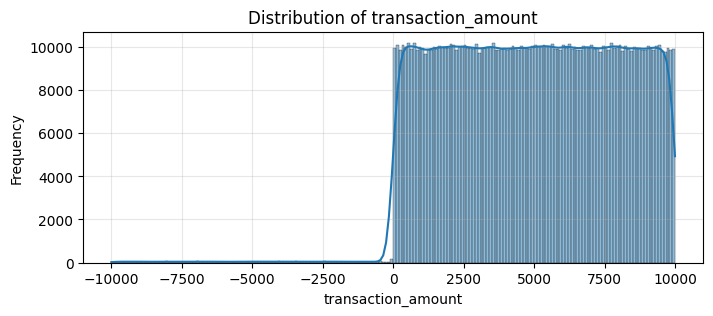

<Figure size 640x480 with 0 Axes>

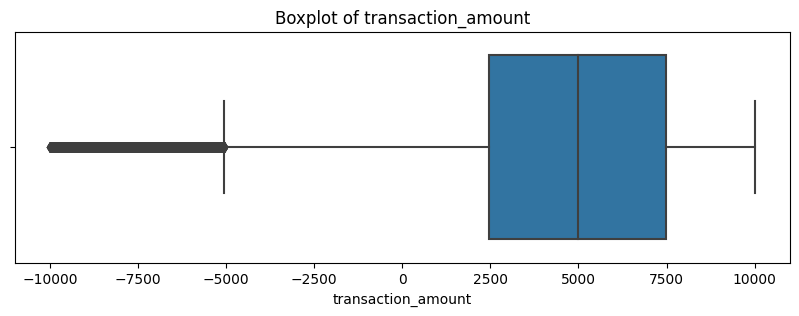

Skewness of transaction_amount: -0.1538
Kurtosis of transaction_amount: -0.5775


<Figure size 640x480 with 0 Axes>

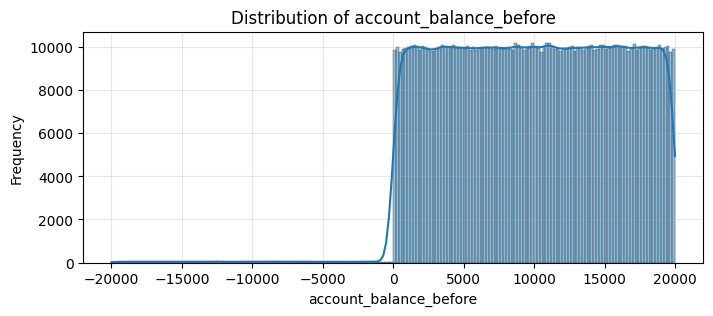

<Figure size 640x480 with 0 Axes>

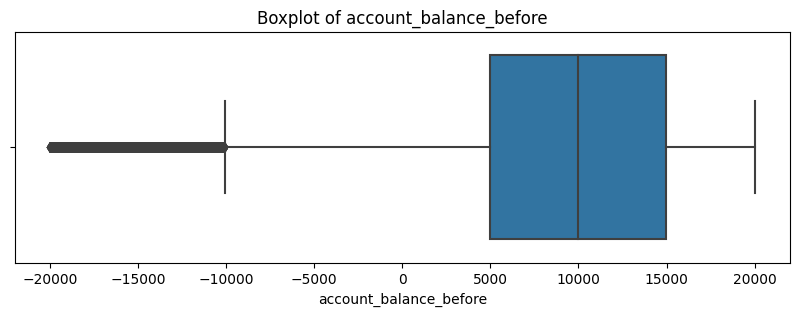

Skewness of account_balance_before: -0.1500
Kurtosis of account_balance_before: -0.6007


<Figure size 640x480 with 0 Axes>

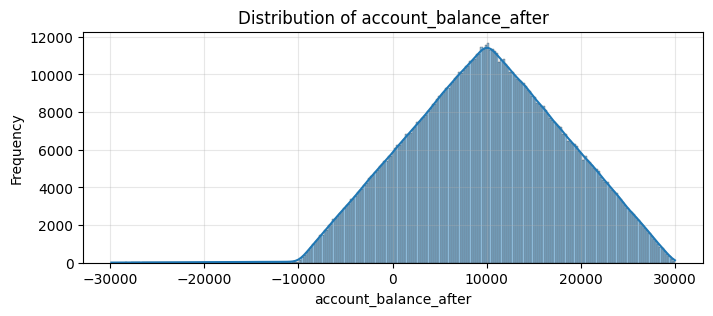

<Figure size 640x480 with 0 Axes>

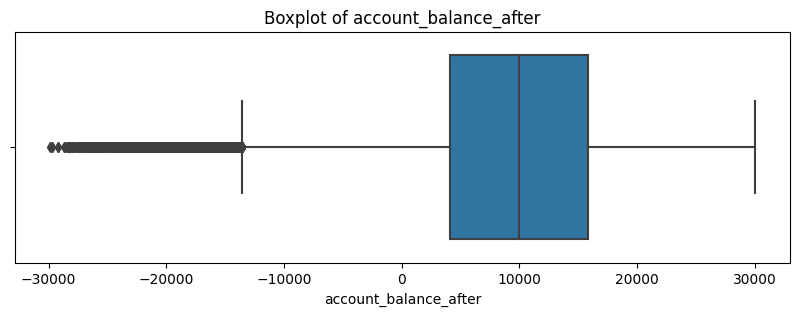

Skewness of account_balance_after: -0.0550
Kurtosis of account_balance_after: -0.4491


<Figure size 640x480 with 0 Axes>

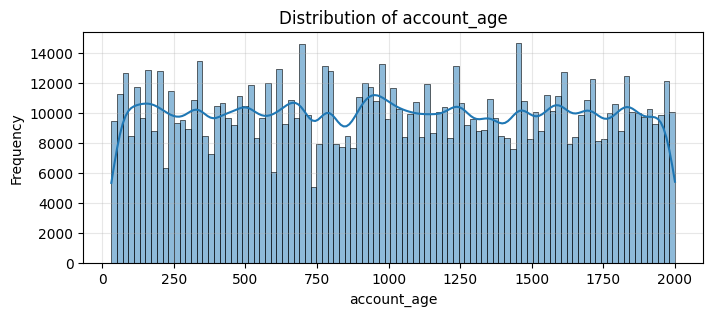

<Figure size 640x480 with 0 Axes>

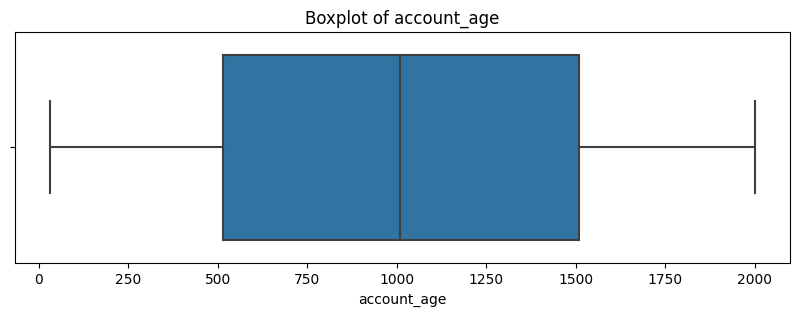

Skewness of account_age: 0.0069
Kurtosis of account_age: -1.1986


<Figure size 640x480 with 0 Axes>

In [22]:
# Distribution of numerical variables
for col in num_cols.drop(['transaction_id', 'customer_id', 'is_fraud'])[:min(7, len(num_cols))]:
    plt.figure(figsize=(8, 3))  
# Histogram and KDE
    sns.histplot(df_merged[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.tight_layout()
        
# Boxplot
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=df_merged[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
    plt.tight_layout()
        
    print(f"Skewness of {col}: {df_merged[col].skew():.4f}")
    print(f"Kurtosis of {col}: {df_merged[col].kurt():.4f}")

**Key Insights**

- Transaction Amount, Account Balance Before and Account Balance After are left skewed and there's also outliers.

- Transaction Amount:
    - Transaction amounts range from approximately -10,000 to +10,000
    - Most transactions appear to cluster within a smaller range, with some notable outliers
- Account Balance:
    - Pre-transaction balances range from about -20,000 to +20,000
    - Post-transaction balances show a similar range but with slightly wider spread
- Account Age:
    - Account ages range from 0 to approximately 2000 units
    - The distribution appears relatively uniform with some fluctuations
    - The histogram in the bottom right shows consistent activity across different age ranges

#### Pairplot

<Figure size 1800x1000 with 0 Axes>

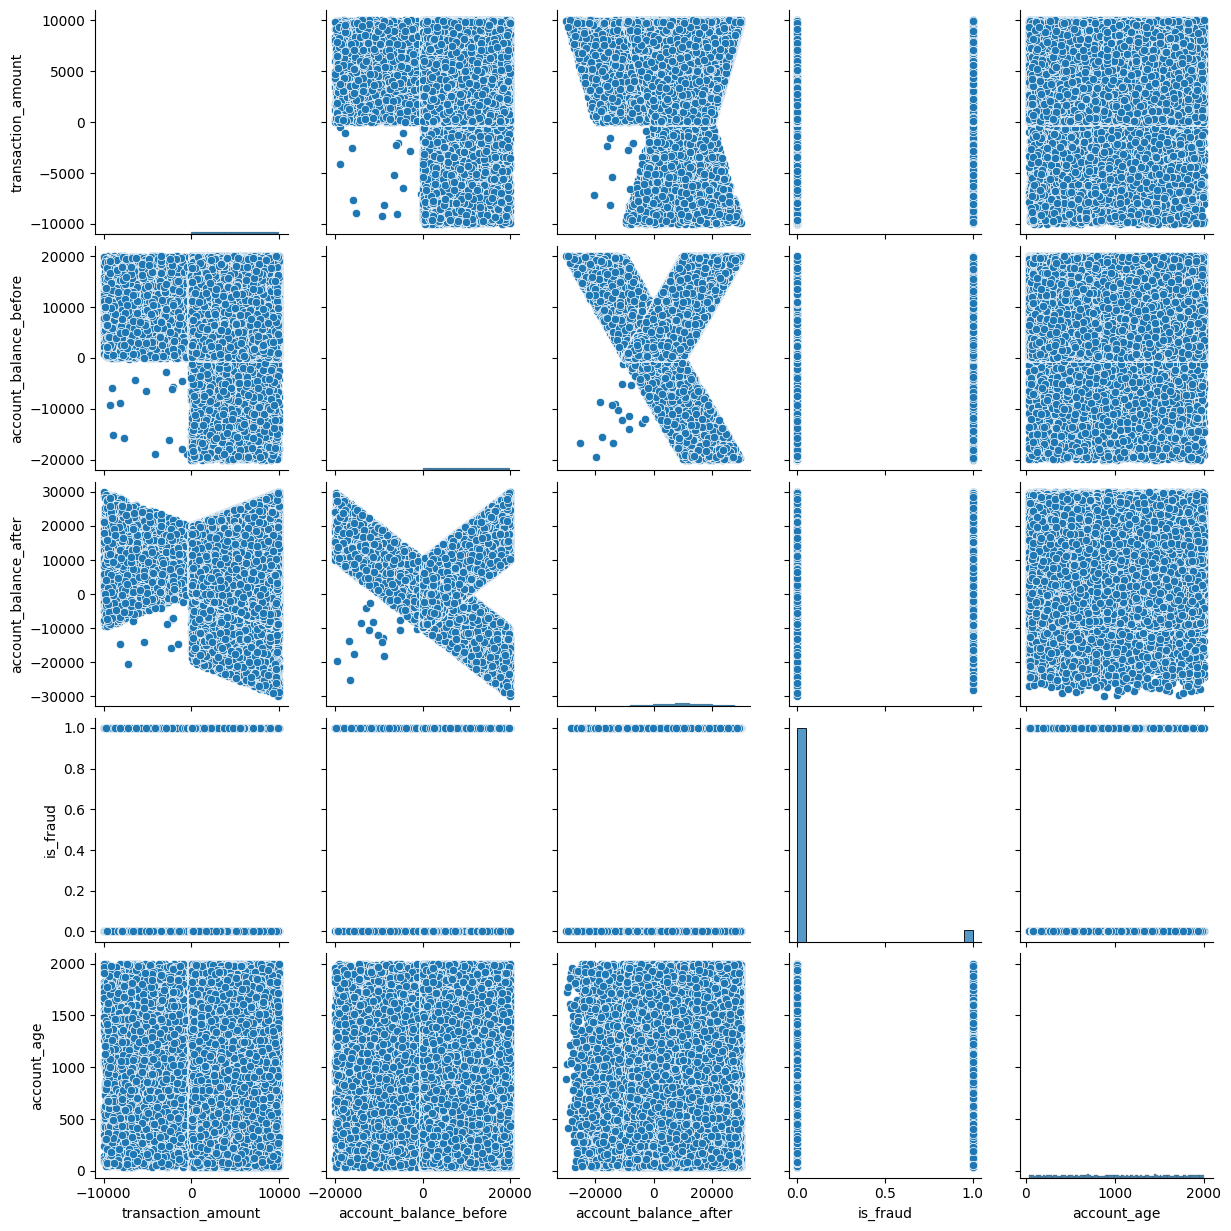

In [23]:
plt.figure(figsize=(18,10))
sns.pairplot(data=df_merged.drop(['transaction_id', 'customer_id'],axis=1))
plt.show() 

- One of the most significant advantages of pair plots is their ability to aid in feature selection. By visually identifying variables that show strong relationships or distinct patterns, data scientists can prioritize these variables for model building. This not only enhances model accuracy but also optimizes computational efficiency by focusing on relevant features.

**Key Insights**

- Account Balance:
    - Strong linear relationships between pre-balance, transaction amount, and post-balance as shown by diagonal patterns.
 - Is Fraud:
    - Distribution between Fraud and Not Fraud is very unbalance.
    - No linear relationships between independent variables with dependent variable.
- Outlier Behavior:
    - Several scattered points away from the main clusters indicate unusual transactions.
    - These outliers are particularly visible in the account balance vs transaction amount plots.
    - They may represent exceptional cases or potentially suspicious activities.

#### Correlation Matrix

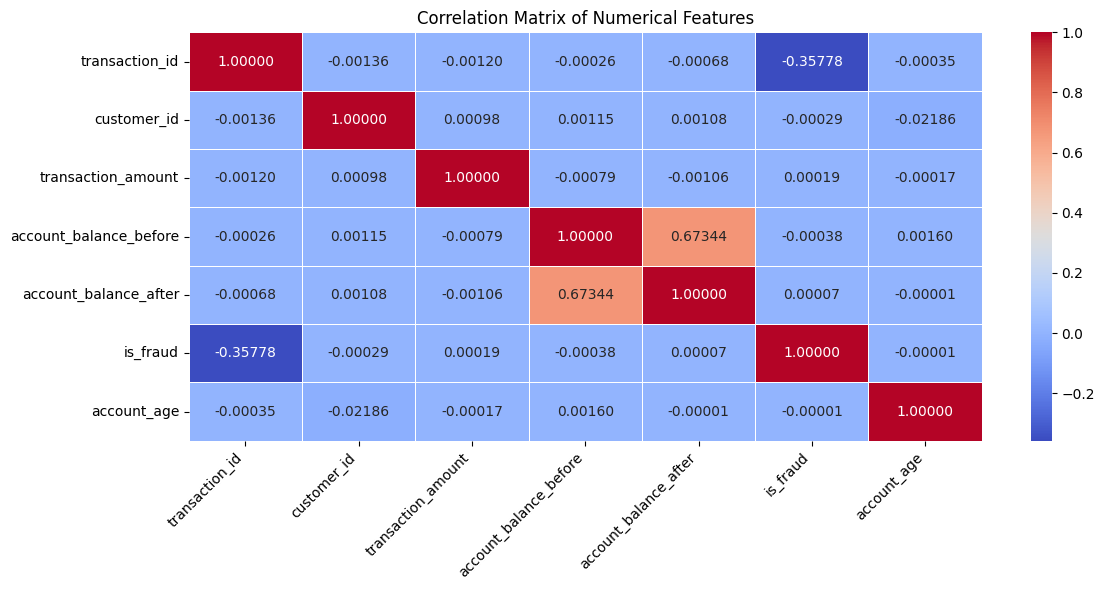

In [24]:
# Correlation analysis for numerical features
if len(num_cols) > 1:
    plt.figure(figsize=(12, 6))
    correlation_matrix = df_merged[num_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".5f") # Convert number to string formatted as 2 decimal places (.2 portion) with floating point representation (f portion).   
    plt.title('Correlation Matrix of Numerical Features')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [25]:
# Strongest correlations
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Remove self-correlations (which are always 1)
corr_pairs = corr_pairs[corr_pairs < 1]
print("\nStrongest correlations:\n",corr_pairs.head(5))


Strongest correlations:
 account_balance_before  account_balance_after     0.673440
account_balance_after   account_balance_before    0.673440
account_age             account_balance_before    0.001604
account_balance_before  account_age               0.001604
                        customer_id               0.001155
dtype: float64


**Key Insights**

- Correlation values close to 0 suggest no linear relationship between the variables.

- In this dataset, there's only one pair has moderate correlation with a value of 0.67 between Account Balance Before and Account Balance After. While, all of the other variables are close to 0 except for Transaction ID and Is Fraud with a value of -0.35. 

- As a result of the negative correlation between the independent variables and dependent variable , they can affect the model. Hence, I will manually remove one before fitting the model.

- Bi-variate analysis techniques provide valuable insights into the relationships between different features in the dataset, helping to understand how they interact and influence each other. Understanding these relationships is crucial for building more accurate models and making informed decisions in data analysis and machine learning tasks.

#### Categorical Variables

In [26]:
cat_cols=df_merged.select_dtypes(include=['object']).columns
print("Categorical Variables:")
print(cat_cols)

Categorical Variables:
Index(['transaction_type', 'payment_method', 'transaction_device',
       'ip_address', 'user_agent', 'merchant_category'],
      dtype='object')


- Graph shows the transaction status of the data. We observe that there are 5% of fraudulent transactions while the remaining 95% were true transactions.

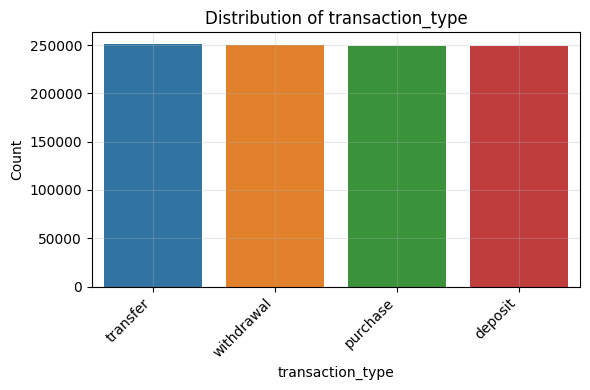

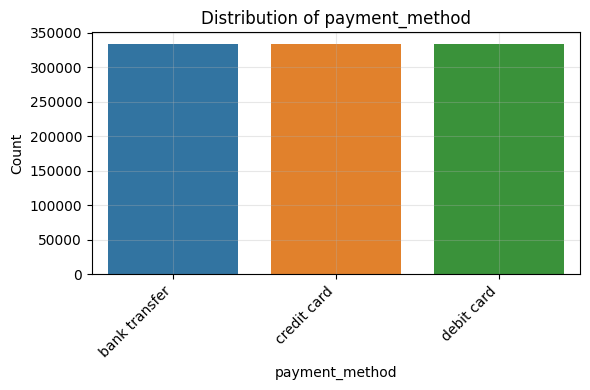

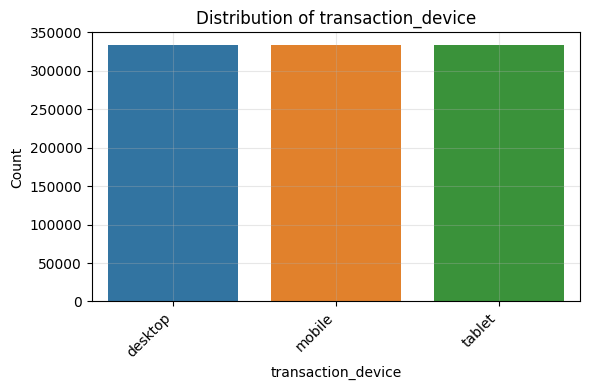

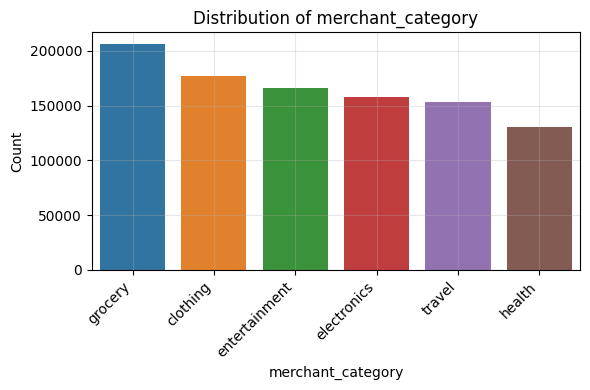

In [27]:
# Analysis of categorical variables
if len(cat_cols) > 0:
    for col in cat_cols[:min(10, len(cat_cols))]:
        if df_merged[col].nunique() < 10:  # Only plot if there're not too many categories
            plt.figure(figsize=(6, 4))
            value_counts = df_merged[col].value_counts().sort_values(ascending=False)
                
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Count')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

In [28]:
# Transaction distribution by transaction type
type_counts = df_merged['transaction_type'].value_counts()
print("\nTransaction Distribution By", type_counts)
# Transaction distribution by payment method
payment_counts = df_merged['payment_method'].value_counts()
print("\nTransaction Distribution By", payment_counts)
# Transaction distribution by transaction deivce
device_counts = df_merged['transaction_device'].value_counts()
print("\nTransaction Distribution By", device_counts)
# Transaction distribution by merchant category
merchant_counts = df_merged['merchant_category'].value_counts()
print("\nTransaction Distribution By", merchant_counts)


Transaction Distribution By transaction_type
transfer      250841
withdrawal    250191
purchase      249708
deposit       249260
Name: count, dtype: int64

Transaction Distribution By payment_method
bank transfer    333582
credit card      333272
debit card       333146
Name: count, dtype: int64

Transaction Distribution By transaction_device
desktop    333437
mobile     333389
tablet     333174
Name: count, dtype: int64

Transaction Distribution By merchant_category
grocery          206686
clothing         177014
entertainment    166124
electronics      158194
travel           153483
health           131014
Name: count, dtype: int64


#### Fraud Status Pattern


Transaction Distribution By is_fraud
0    949999
1     50001
Name: count, dtype: int64


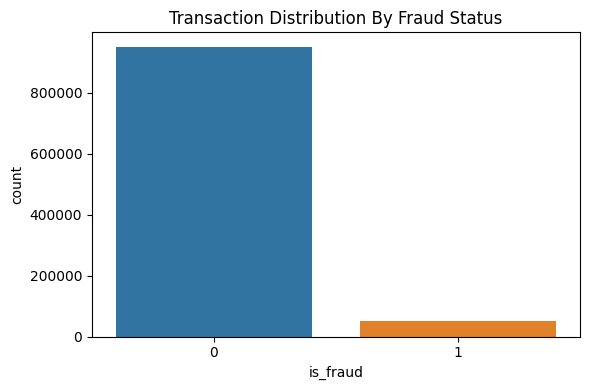

In [29]:
# Transaction distribution by fraud status
fraud_counts = df_merged['is_fraud'].value_counts()
print("\nTransaction Distribution By", fraud_counts)

# Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_merged, order=fraud_counts .index)
plt.title('Transaction Distribution By Fraud Status')
plt.tight_layout()

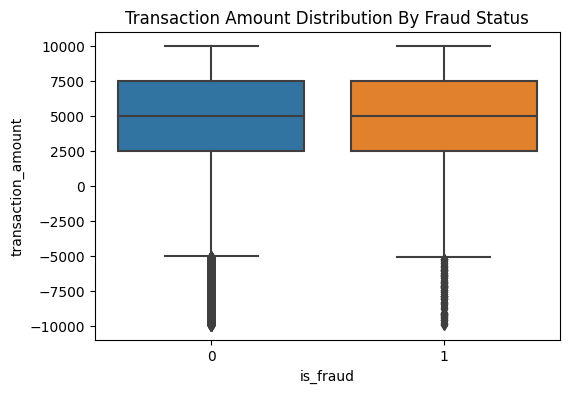

In [30]:
# Transaction amount distribution by fraud status
plt.figure(figsize=(6, 4))
sns.boxplot(x='is_fraud', y='transaction_amount', data=df_merged)
plt.title('Transaction Amount Distribution By Fraud Status')
plt.show()

- Transaction Amount of fraudulent transactions falls between -$5000 and $10,0000, and 50% of fraudulent transactions is greater than $5000.

- Distribution of the fraudulent and non-fraudulent is seen to be skewed to the right as well as outliers.

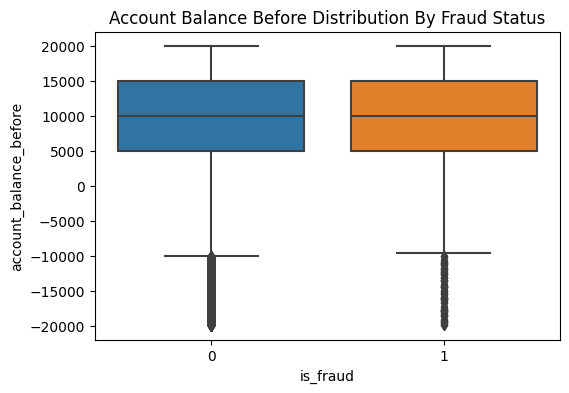

In [31]:
# Transaction amount distribution by fraud status
plt.figure(figsize=(6, 4))
sns.boxplot(x='is_fraud', y='account_balance_before', data=df_merged)
plt.title('Account Balance Before Distribution By Fraud Status')
plt.show()

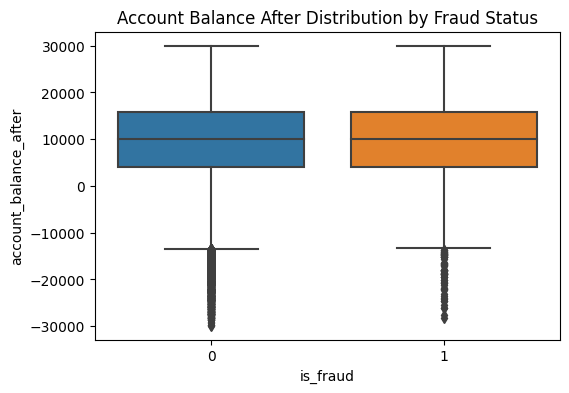

In [32]:
# Transaction amount distribution by fraud status
plt.figure(figsize=(6, 4))
sns.boxplot(x='is_fraud', y='account_balance_after', data=df_merged)
plt.title('Account Balance After Distribution by Fraud Status')
plt.show()

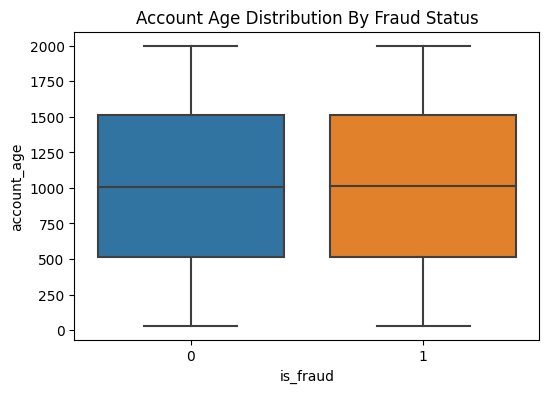

In [33]:
# Transaction amount distribution by fraud status
plt.figure(figsize=(6, 4))
sns.boxplot(x='is_fraud', y='account_age', data=df_merged)
plt.title('Account Age Distribution By Fraud Status')
plt.show()

- Account Age of fraudulent transactions falls between 0 and 2000 days. Median is 1000 days, thus 50% of the fraudulent transactions were happened to those accounts that higher than 1000 days old. 

- Distribution of the Fraudulent and Non-Fraudulent is seen to be balanced as well as no outliers.

In [34]:
# Transaction type distribution by fraud status
fraud_by_type = df_merged.groupby('transaction_type')['is_fraud'].value_counts()
print("Transaction Type Distribution By Fraud Status\n", fraud_by_type)
# Transaction device distribution by fraud status
fraud_by_device = df_merged.groupby('transaction_device')['is_fraud'].value_counts()
print("\nTransaction Device Distribution By Fraud Status\n", fraud_by_device)

Transaction Type Distribution By Fraud Status
 transaction_type  is_fraud
deposit           0           236777
                  1            12483
purchase          0           237261
                  1            12447
transfer          0           238287
                  1            12554
withdrawal        0           237674
                  1            12517
Name: count, dtype: int64

Transaction Device Distribution By Fraud Status
 transaction_device  is_fraud
desktop             0           316917
                    1            16520
mobile              0           316624
                    1            16765
tablet              0           316458
                    1            16716
Name: count, dtype: int64


In [35]:
# Payment method distribution by fraud status
fraud_by_payment = df_merged.groupby('payment_method')['is_fraud'].value_counts()
print("Payment Method Distribution By Fraud Status\n", fraud_by_payment)
# Merchant category distribution by fraud status
fraud_by_merchant = df_merged.groupby('merchant_category')['is_fraud'].value_counts()
print("\nMerchant Category Distribution By Fraud Status\n", fraud_by_merchant)

Payment Method Distribution By Fraud Status
 payment_method  is_fraud
bank transfer   0           317038
                1            16544
credit card     0           316481
                1            16791
debit card      0           316480
                1            16666
Name: count, dtype: int64

Merchant Category Distribution By Fraud Status
 merchant_category  is_fraud
clothing           0           168005
                   1             9009
electronics        0           150178
                   1             8016
entertainment      0           157964
                   1             8160
grocery            0           196131
                   1            10555
health             0           124425
                   1             6589
travel             0           145811
                   1             7672
Name: count, dtype: int64


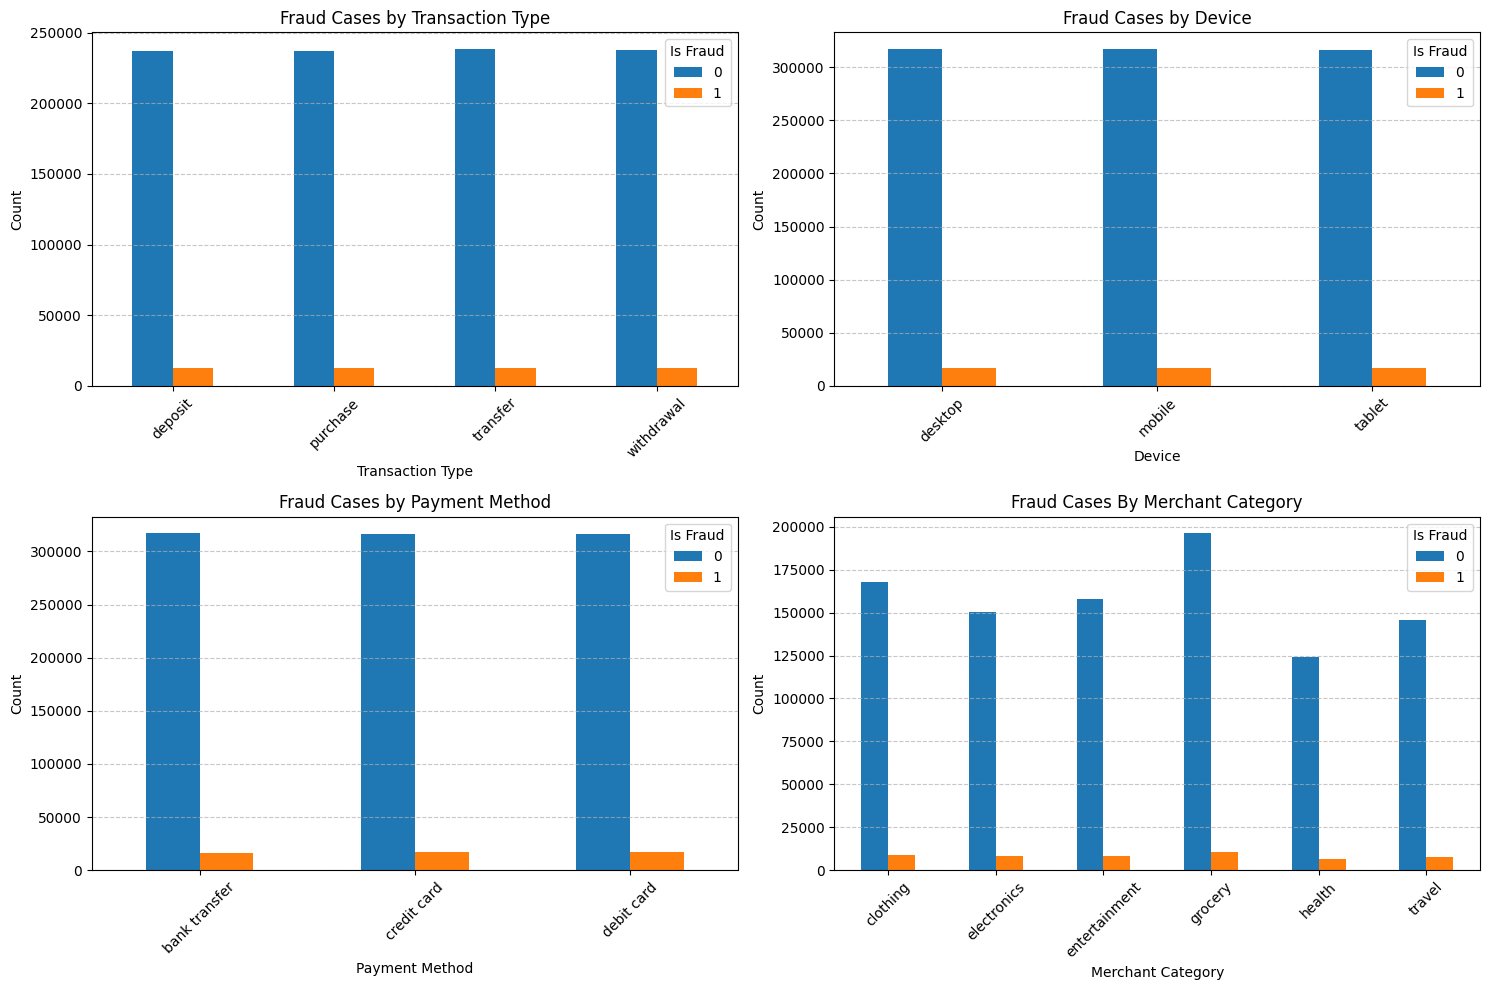

In [36]:
# Create a figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Fraud by Transaction Type
fraud_by_type.unstack().plot(kind='bar', ax=ax1)
ax1.set_title('Fraud Cases by Transaction Type')
ax1.set_xlabel('Transaction Type')
ax1.set_ylabel('Count')
ax1.legend(title='Is Fraud')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Fraud by Device
fraud_by_device.unstack().plot(kind='bar', ax=ax2)
ax2.set_title('Fraud Cases by Device')
ax2.set_xlabel('Device')
ax2.set_ylabel('Count')
ax2.legend(title='Is Fraud')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Fraud by Payment Method
fraud_by_payment.unstack().plot(kind='bar', ax=ax3)
ax3.set_title('Fraud Cases by Payment Method')
ax3.set_xlabel('Payment Method')
ax3.set_ylabel('Count')
ax3.legend(title='Is Fraud')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Fraud by Merchant Category
fraud_by_merchant.unstack().plot(kind='bar', ax=ax4, stacked=False)
ax4.set_title('Fraud Cases By Merchant Category')
ax4.set_xlabel('Merchant Category')
ax4.set_ylabel('Count')
ax4.legend(title='Is Fraud')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Trend Overtime

    transaction_timestamp  transaction_count
0              2021-04-24               1417
1              2021-04-25               1393
2              2021-04-26               1370
3              2021-04-27               1370
4              2021-04-28               1386
..                    ...                ...
727            2023-04-20               1327
728            2023-04-21               1376
729            2023-04-22               1367
730            2023-04-23               1341
731            2023-04-24               1366

[732 rows x 2 columns]


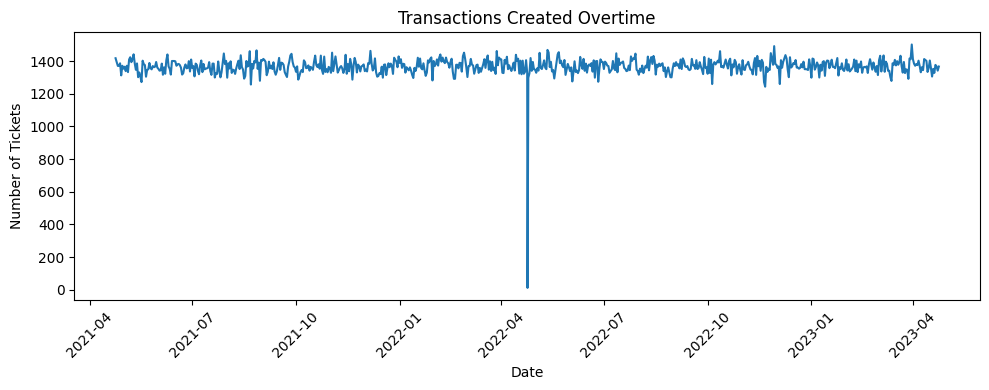

In [37]:
# Transactions created overtime
transaction_overtime = df_merged.groupby('transaction_timestamp').size().reset_index()
transaction_overtime.columns = ['transaction_timestamp', 'transaction_count']
print(transaction_overtime)

# Visualize trends
plt.figure(figsize=(10, 4))
plt.plot(transaction_overtime['transaction_timestamp'], transaction_overtime['transaction_count'])
plt.title('Transactions Created Overtime')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45)
plt.tight_layout()

Day of Week Distribution by Fraud Status
 day_of_week  is_fraud
0            0           136025
             1             7205
1            0           135278
             1             7170
2            0           135040
             1             7168
3            0           135264
             1             7024
4            0           135827
             1             7108
5            0           136745
             1             7194
6            0           135820
             1             7132
Name: count, dtype: int64


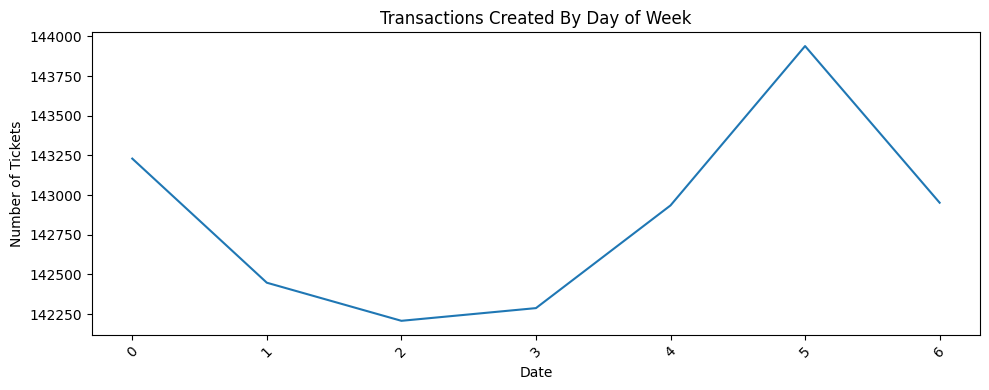

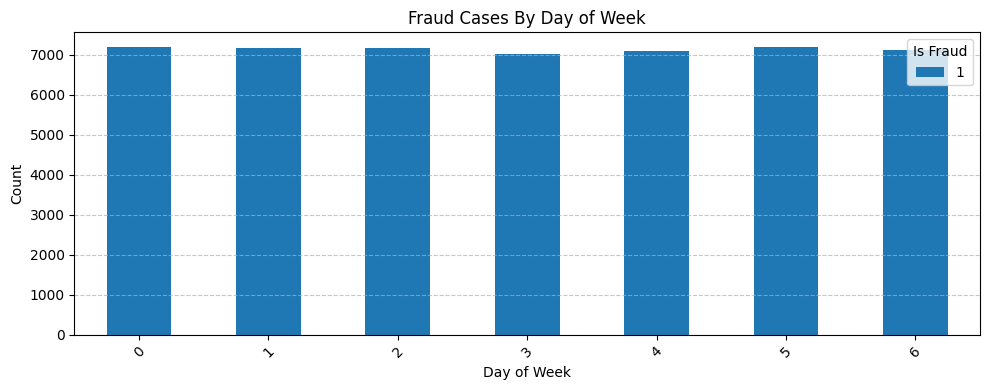

In [38]:
# Create day of week-only column for trend analysis
df_merged['day_of_week'] = df_merged['transaction_timestamp'].dt.dayofweek
# Transactions created by day of week
transaction_dow = df_merged.groupby('day_of_week').size().reset_index()
transaction_dow.columns = ['day_of_week', 'transaction_count']
#print(transaction_dow)
# Day of week distribution by fraud status
fraud_by_dow = df_merged.groupby('day_of_week')['is_fraud'].value_counts()
print("Day of Week Distribution by Fraud Status\n", fraud_by_dow)

# Day of week transaction created
plt.figure(figsize=(10, 4))
plt.plot(transaction_dow['day_of_week'], transaction_dow['transaction_count'])
plt.title('Transactions Created By Day of Week')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45)
plt.tight_layout()

# Fraud Cases by day of week
plt.figure(figsize=(10, 4))
fraud_by_dow.unstack()[1].plot(kind='bar', stacked=False)
# Customize the plot
plt.title('Fraud Cases By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Add grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

- Majority of the fraudulent transactions occurred on **Sunday** with 7205 and on **Thursday** with 7194 fraudulent transactions. 

- **Sunday** has the highest number of fraud transactions among other days of the week.

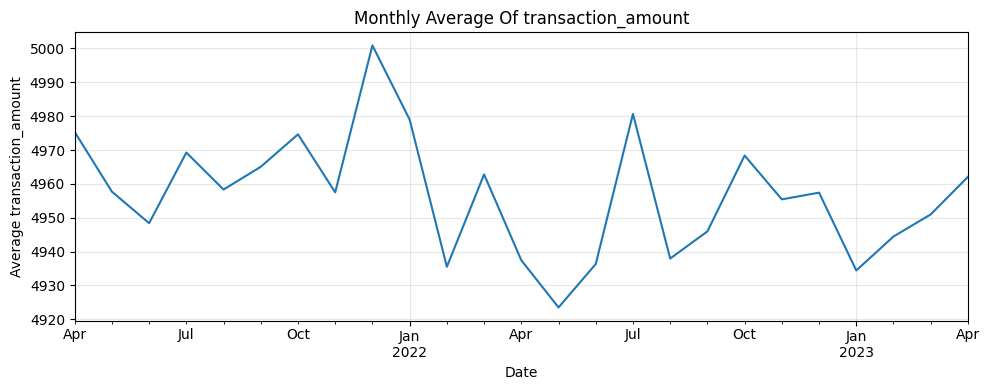

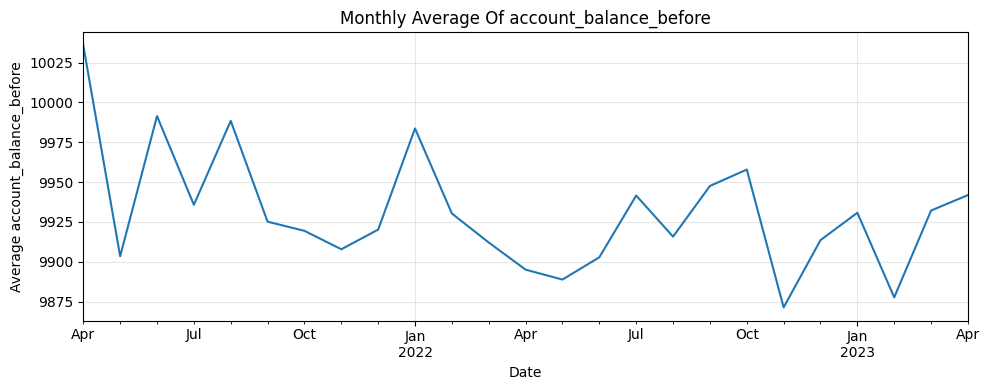

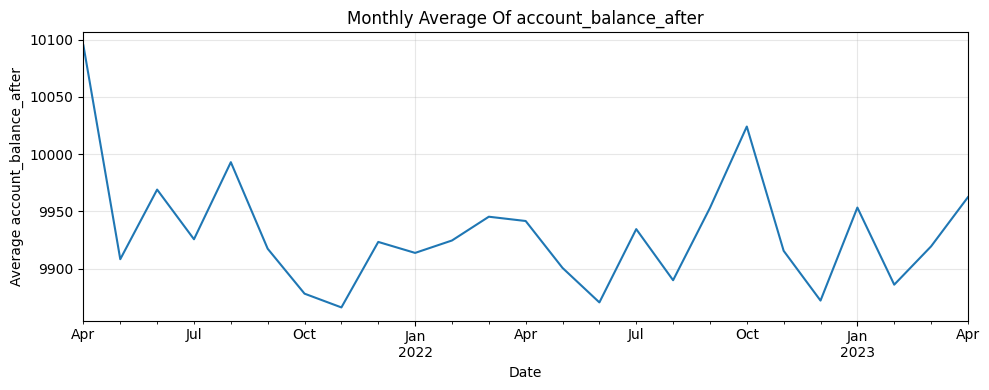

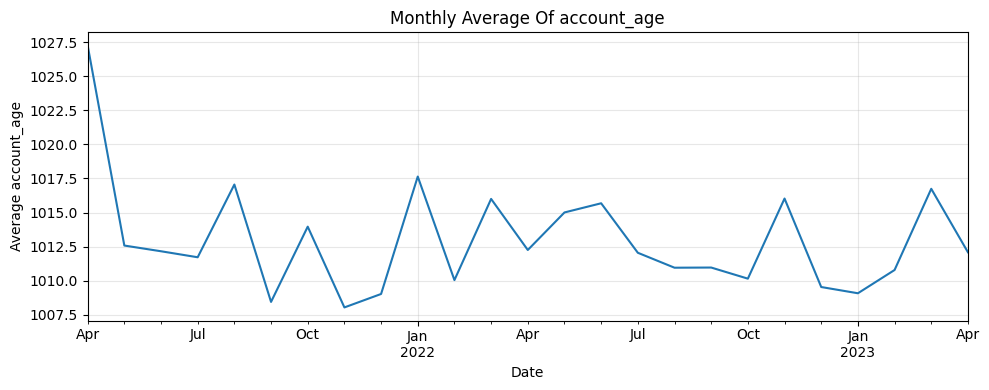

In [39]:
date_cols = df_merged.select_dtypes(include=['datetime64']).columns
date_cols

# Time series analysis if any date columns exist
if len(date_cols) > 0:
    for date_col in date_cols:
        try:
            # Group by date at an appropriate level and analyze key metrics
            for num_col in num_cols.drop(['transaction_id', 'customer_id', 'is_fraud'])[:min(5, len(num_cols))]:
                # Determine best time grouping based on date range
                date_range = (df_merged[date_col].max() - df_merged[date_col].min()).days
                    
                if date_range > 365:  # More than 2 years
                    freq = 'M'  # Monthly
                    title_freq = "Monthly"
                elif date_range > 30:  # More than 2 months
                    freq = 'W'  # Weekly
                    title_freq = "Weekly"
                else:
                    freq = 'D'  # Daily
                    title_freq = "Daily"
                    
                # Group by time period and calculate mean
                time_series = df_merged.set_index(date_col)[num_col].resample(freq).mean()
                    
                # Plot the time series
                plt.figure(figsize=(10, 4))
                time_series.plot()
                plt.title(f'{title_freq} Average Of {num_col}')
                plt.xlabel('Date')
                plt.ylabel(f'Average {num_col}')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Error in time series analysis: {e}")

----

### Data Preprocessing

#### Feature Engineering

In [40]:
df_merged.head()

,transaction_id,customer_id,transaction_timestamp,transaction_amount,transaction_type,payment_method,account_balance_before,account_balance_after,transaction_device,ip_address,user_agent,is_fraud,account_age,merchant_category,day_of_week
0,1,115,2022-12-21,392.44,transfer,debit card,7032.36,7424.80,tablet,7.53.209.71,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.0; Trident/4.0),1,668.0,grocery,2
1,2,2395,2021-12-11,594.18,deposit,debit card,11503.03,12097.21,mobile,108.229.29.188,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) Gecko/2076-06-03 06:34:31 Firefox/3.8,0,1023.0,grocery,5
2,3,2082,2022-04-11,6363.16,transfer,credit card,16073.25,22436.41,desktop,148.218.101.152,"Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_9_1 rv:5.0; sr-ME) AppleWebKit/535.49.1 (KHTML, like Gecko) Version/4.0.2 Safari/535.49.1",1,1843.0,entertainment,0
3,4,315,2022-09-24,2834.45,deposit,debit card,16938.44,19772.89,mobile,14.38.239.68,"Mozilla/5.0 (Windows 98) AppleWebKit/533.1 (KHTML, like Gecko) Chrome/53.0.881.0 Safari/533.1",0,132.0,grocery,5
4,5,2055,2021-08-11,4117.41,deposit,credit card,8686.47,12803.88,desktop,1.93.31.164,Mozilla/5.0 (X11; Linux i686; rv:1.9.7.20) Gecko/7581-11-18 22:15:14 Firefox/3.6.16,0,1579.0,grocery,2


In [41]:
# Calculate transaction amount mean per customer
customer_stats = df_merged.groupby('customer_id')['transaction_amount'].agg(['mean']).reset_index().round(2)
customer_stats.columns = ['customer_id', 'mean_customer_amount']
print("Mean of Transaction Amount By Customer:\n", customer_stats)

Mean of Transaction Amount By Customer:
       customer_id  mean_customer_amount
0               1               4864.66
1               2               4971.31
2               3               5050.75
3               4               5013.85
4               5               4879.71
...           ...                   ...
2495         2496               5118.07
2496         2497               4973.04
2497         2498               5159.72
2498         2499               5026.37
2499         2500               5084.96

[2500 rows x 2 columns]


In [42]:
# Feature engineering
def create_advanced_features(df):

    # Create feature for average transaction amount per customer
    df = df.merge(customer_stats, on='customer_id')

    # Create feature for transaction amount against customer average
    df['amount_vs_avg'] = df['transaction_amount'] / df['mean_customer_amount']

    # Calculate transaction frequency
    df['transaction_count'] = df.groupby('customer_id')['transaction_id'].transform('count')

    # Balance feature
    df['balance_change'] = (df['account_balance_after'] - df['account_balance_before'])
    
    return df

df_merged = create_advanced_features(df_merged)
df_merged.head()

,transaction_id,customer_id,transaction_timestamp,transaction_amount,transaction_type,payment_method,account_balance_before,account_balance_after,transaction_device,ip_address,user_agent,is_fraud,account_age,merchant_category,day_of_week,mean_customer_amount,amount_vs_avg,transaction_count,balance_change
0,1,115,2022-12-21,392.44,transfer,debit card,7032.36,7424.80,tablet,7.53.209.71,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.0; Trident/4.0),1,668.0,grocery,2,5208.24,0.075350,365,392.44
1,2977,115,2022-06-06,6204.39,transfer,debit card,5723.50,11927.89,mobile,7.252.200.103,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.2; Trident/5.1),0,668.0,grocery,0,5208.24,1.191264,365,6204.39
2,6797,115,2022-09-27,3040.74,deposit,credit card,15252.64,18293.38,desktop,217.27.130.218,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.2; Trident/5.1),0,668.0,grocery,1,5208.24,0.583833,365,3040.74
3,17772,115,2022-01-11,1679.82,withdrawal,debit card,13392.68,11712.86,tablet,134.70.222.148,"Mozilla/5.0 (iPad; CPU iPad OS 6_1_6 like Mac OS X) AppleWebKit/532.0 (KHTML, like Gecko) CriOS/33.0.813.0 Mobile/15C153 Safari/532.0",0,668.0,grocery,1,5208.24,0.322531,365,-1679.82
4,21309,115,2022-07-01,9544.09,withdrawal,credit card,6023.86,-3520.23,mobile,65.248.113.76,Mozilla/5.0 (compatible; MSIE 5.0; Windows CE; Trident/3.1),1,668.0,grocery,4,5208.24,1.832498,365,-9544.09


- I won't use One-Hot-Encoding becasue i'm going to use tree-based algorithms. Instead, will use Label (Low cardinality) and Target Encoding (High cardinality).

In [43]:
# Split to train/test datasets with ratio 0.8/0.2 and random_state=42.   
target_col = 'is_fraud'
X = df_merged.drop(['is_fraud', 'transaction_id', 'customer_id', 'transaction_timestamp'], axis=1)
y = df_merged[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
print("Train Dimensions:",X_train.shape)
print("Test Dimensions:",X_test.shape)
print("Response Column:",np.unique(y, return_counts=True))

Train Dimensions: (800000, 15)
Test Dimensions: (200000, 15)
Response Column: (array([0, 1]), array([949999,  50001]))


In [45]:
len_data = len(X_train)
for col in X_train.columns:
  if X_train[col].dtype == 'object':
    print("Column ",col," has ",X_train[col].nunique()," values")

Column  transaction_type  has  4  values
Column  payment_method  has  3  values
Column  transaction_device  has  3  values
Column  ip_address  has  799904  values
Column  user_agent  has  603261  values
Column  merchant_category  has  6  values


#### Label Econding

In [46]:
orig_categorical_columns = []
cat_encoders = {}
le_columns = []

for col in X_train.columns:
  if X_train[col].dtype == 'object':
    if X_train[col].nunique() > 7:
      print("Label Encoding", col)
      enc = LabelEncoder()
      enc.fit(list(X_train[col])+list(X_test[col]))
      X_train[col+"_le"] = enc.transform(X_train[[col]])
      X_test[col+"_le"] = enc.transform(X_test[[col]])
      cat_encoders[(col,"le")] = [deepcopy(enc),"le"]
      orig_categorical_columns.append(col)
      le_columns.append(col+"_le")

Label Encoding ip_address
Label Encoding user_agent


In [47]:
le_columns

['ip_address_le', 'user_agent_le']

#### Target Encoding

In [48]:
enc_columns = ['transaction_type', 'payment_method', 'transaction_device', 'merchant_category']

# Target encoding
target_encoder = ce.TargetEncoder (min_samples_leaf=20, smoothing=10)
target_encoder.fit(X_train[enc_columns],y_train)
X_train_target_enc = target_encoder.transform(X_train[enc_columns])
X_test_target_enc = target_encoder.transform(X_test[enc_columns])

te_columns = []
for col in enc_columns:
    X_train[col+'_te'] = X_train_target_enc[col]
    X_test[col+'_te'] = X_test_target_enc[col]
    orig_categorical_columns.append(col)
    te_columns.append(col+"_te")

cat_encoders[(col,'te')] = [deepcopy(target_encoder),'te']

In [49]:
te_columns

['transaction_type_te',
 'payment_method_te',
 'transaction_device_te',
 'merchant_category_te']

#### Standardize Variables

In [50]:
num_orig_columns = X_train.select_dtypes(include=np.number).drop(columns = te_columns + le_columns).columns
print(num_orig_columns)

Index(['transaction_amount', 'account_balance_before', 'account_balance_after',
       'account_age', 'day_of_week', 'mean_customer_amount', 'amount_vs_avg',
       'transaction_count', 'balance_change'],
      dtype='object')


In [51]:
columns_to_scale = X_train.select_dtypes(include=np.number).columns
print("Columns to scale: ", columns_to_scale)

Columns to scale:  Index(['transaction_amount', 'account_balance_before', 'account_balance_after',
       'account_age', 'day_of_week', 'mean_customer_amount', 'amount_vs_avg',
       'transaction_count', 'balance_change', 'ip_address_le', 'user_agent_le',
       'transaction_type_te', 'payment_method_te', 'transaction_device_te',
       'merchant_category_te'],
      dtype='object')


In [52]:
num_scalers = {}
cols_numerical_sc = []

# Scale only original numerical columns
for col in X_train[columns_to_scale]:
    print("StandardScaler of", col)
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])
    X_train[col+"_sc"] = scaler.transform(X_train[[col]])
    X_test[col+"_sc"] = scaler.transform(X_test[[col]])

    num_scalers[col] = [deepcopy(scaler),"StandardScaler"]
    cols_numerical_sc.append(col+"_sc")

StandardScaler of transaction_amount
StandardScaler of account_balance_before
StandardScaler of account_balance_after
StandardScaler of account_age
StandardScaler of day_of_week
StandardScaler of mean_customer_amount
StandardScaler of amount_vs_avg
StandardScaler of transaction_count
StandardScaler of balance_change
StandardScaler of ip_address_le
StandardScaler of user_agent_le
StandardScaler of transaction_type_te
StandardScaler of payment_method_te
StandardScaler of transaction_device_te
StandardScaler of merchant_category_te


In [53]:
print("Scaled columns:", cols_numerical_sc)

Scaled columns: ['transaction_amount_sc', 'account_balance_before_sc', 'account_balance_after_sc', 'account_age_sc', 'day_of_week_sc', 'mean_customer_amount_sc', 'amount_vs_avg_sc', 'transaction_count_sc', 'balance_change_sc', 'ip_address_le_sc', 'user_agent_le_sc', 'transaction_type_te_sc', 'payment_method_te_sc', 'transaction_device_te_sc', 'merchant_category_te_sc']


In [54]:
orig_categorical_columns

['ip_address',
 'user_agent',
 'transaction_type',
 'payment_method',
 'transaction_device',
 'merchant_category']

In [55]:
num_orig_columns

Index(['transaction_amount', 'account_balance_before', 'account_balance_after',
       'account_age', 'day_of_week', 'mean_customer_amount', 'amount_vs_avg',
       'transaction_count', 'balance_change'],
      dtype='object')

In [56]:
columns_to_scale

Index(['transaction_amount', 'account_balance_before', 'account_balance_after',
       'account_age', 'day_of_week', 'mean_customer_amount', 'amount_vs_avg',
       'transaction_count', 'balance_change', 'ip_address_le', 'user_agent_le',
       'transaction_type_te', 'payment_method_te', 'transaction_device_te',
       'merchant_category_te'],
      dtype='object')

In [57]:
X_train = X_train.drop(columns=orig_categorical_columns).drop(columns=columns_to_scale)

X_test = X_test.drop(columns=orig_categorical_columns).drop(columns=columns_to_scale)

print("Number of Model Features: ", X_train.shape[1])

Number of Model Features:  15


In [58]:
print("Train Dimensions:",X_train.shape)
print("Test Dimensions:",X_test.shape)

Train Dimensions: (800000, 15)
Test Dimensions: (200000, 15)


In [59]:
X_train.head()

,transaction_amount_sc,account_balance_before_sc,account_balance_after_sc,account_age_sc,day_of_week_sc,mean_customer_amount_sc,amount_vs_avg_sc,transaction_count_sc,balance_change_sc,ip_address_le_sc,user_agent_le_sc,transaction_type_te_sc,payment_method_te_sc,transaction_device_te_sc,merchant_category_te_sc
566853,1.604419,-0.228724,-1.337409,-1.001497,0.497879,-0.382866,1.640844,-0.546607,-1.586329,-1.624783,0.192502,0.504236,-0.863486,0.570942,0.275093
382311,-0.992558,-0.532862,-0.135771,-0.096751,0.997584,-1.008828,-0.971456,-0.745252,0.331233,1.068816,0.192805,-0.859181,1.401241,0.834449,-0.007291
241519,0.550306,-1.480279,-1.854706,1.456748,-1.500940,0.509845,0.517424,-2.086102,-1.076455,-0.957459,1.846493,-1.041580,-0.863486,0.834449,0.253836
719220,1.189230,-0.326298,-1.258540,-0.017848,0.497879,1.461641,1.071511,-2.086102,-1.385502,1.697060,0.192432,-1.041580,1.401241,0.834449,-0.007291
905718,0.876194,-0.335651,-1.153175,-1.499458,-0.501531,-0.706282,0.929550,1.588821,-1.234087,1.361293,1.229569,0.504236,-0.538617,-1.406604,-0.278006


----

### Models Training

#### Train Models with Default Parameters

In [60]:
dtc = DecisionTreeClassifier().fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)
print("Decision Tree Accuracy Test Score: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Accuracy Test Score: 0.89


In [61]:
# Area under the precision - recall 
print("AUCPR:",average_precision_score(y_true=y_test, y_score=dtc.predict_proba(X_test)[:,1]))

# F1 score
print("\nF1 Score On Test: {:.2f}".format(f1_score(y_test, pred_dtc, average="weighted")))

# Confusion matrix
print("\nDecision Tree Confusion Matrix")
print(confusion_matrix(y_test, pred_dtc))

# Classification report
print("\nClassification Report")
print(classification_report(y_test, pred_dtc, target_names=["Not One", "Digit One"], zero_division=0))

AUCPR: 0.050172207861560965

F1 Score On Test: 0.90

Decision Tree Confusion Matrix
[[177972  12018]
 [  9352    658]]

Classification Report
              precision    recall  f1-score   support

     Not One       0.95      0.94      0.94    189990
   Digit One       0.05      0.07      0.06     10010

    accuracy                           0.89    200000
   macro avg       0.50      0.50      0.50    200000
weighted avg       0.91      0.89      0.90    200000



- TP: 178,005 samples is the total counts having both predict and actual values are **0 (Not Fraud)**
- TN: 731 samples is the total counts having both predicted and actual values are **1 (Fraud)**

- FP: 9279 samples is the total counts having prediction is 0 while actually is **1 (Fraud)**
- FN: 11,985 samples is the total counts having prediction is 1 while actually is **0 (Not Fraud)**

In [62]:
rfc = RandomForestClassifier().fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
print("Random Forest Accuracy Test Score: {:.2f}".format(rfc.score(X_test, y_test)))

Random Forest Accuracy Test Score: 0.95


In [63]:
# Area under the precision - recall 
print("AUCPR:",average_precision_score(y_true=y_test, y_score=rfc.predict_proba(X_test)[:,1]))

# F1 score
print("\nF1 Score On Test: {:.2f}".format(f1_score(y_test, pred_rfc, average="weighted")))

# Confusion matrix
print("\nRandom Forest Confusion Matrix")
print(confusion_matrix(y_test, pred_rfc))

# Classification report
print("\nClassification Report")
print(classification_report(y_test, pred_rfc, target_names=["Not One", "Digit One"], zero_division=0))

AUCPR: 0.05154981580002489

F1 Score On Test: 0.93

Random Forest Confusion Matrix
[[189990      0]
 [ 10010      0]]

Classification Report
              precision    recall  f1-score   support

     Not One       0.95      1.00      0.97    189990
   Digit One       0.00      0.00      0.00     10010

    accuracy                           0.95    200000
   macro avg       0.47      0.50      0.49    200000
weighted avg       0.90      0.95      0.93    200000



- TP: 189,990 samples is the total counts having both predict and actual values are **0 (Not Fraud)**
- TN: 0 samples is the total counts having both predicted and actual values are **1 (Fraud)**

- FP: 0 samples is the total counts having prediction is **0 (Not Fraud)** while actually is **1 (Fraud)**
- FN: 10,010 samples is the total counts having prediction is **1 (Fraud)** while actually is **0 (Not Fraud)**

In [64]:
logreg = LogisticRegression().fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("Logistic Accuracy Test Score: {:.2f}".format(logreg.score(X_test, y_test)))

Logistic Accuracy Test Score: 0.95


In [65]:
# Area under the precision - recall 
print("AUCPR:",average_precision_score(y_true=y_test, y_score=logreg.predict_proba(X_test)[:,1]))

# F1 score
print("\nF1 Score On Test: {:.2f}".format(f1_score(y_test, pred_logreg, average="weighted")))

# Confusion matrix
print("\nLogistic Regression Confusion Matrix")
print(confusion_matrix(y_test, pred_logreg))

# Classification report
print("\nClassification Report")
print(classification_report(y_test, pred_logreg, target_names=["Not One", "Digit One"], zero_division=0))

AUCPR: 0.05018095714030574

F1 Score On Test: 0.93

Logistic Regression Confusion Matrix
[[189990      0]
 [ 10010      0]]

Classification Report
              precision    recall  f1-score   support

     Not One       0.95      1.00      0.97    189990
   Digit One       0.00      0.00      0.00     10010

    accuracy                           0.95    200000
   macro avg       0.47      0.50      0.49    200000
weighted avg       0.90      0.95      0.93    200000



- TP: 189,990 samples is the total counts having both predict and actual values are **0 (Not Fraud)**
- TN: 0 samples is the total counts having both predicted and actual values are **1 (Fraud)**

- FP: 10,010 samples is the total counts having prediction is **0 (Not Fraud)** while actually is **1 (Fraud)**
- FN: 0 samples is the total counts having prediction is **1 (Fraud)** while actually is **0 (Not Fraud)**

AUCPR is metric to evaluate the performance of binary classification model and a model's ability to identify positive instances correctly, especially when the positive class is rare or when false positives are more significant than false negatives. A higher AUC-PR score indicates better performance, meaning the model is better at identifying positive instances with high precision.

- I'm using AUCPR because PR-AUC is particularly useful for evaluating models on imbalanced datasets, where one class is significantly underrepresented, as it focuses on the performance of the minority class. Value closer to 0 indicating worse performance, especially in imbalanced datasets.

- Out of the many algorithms trained, the best models for predicting credit card fraud were found to be Random Forest and Logistic Regression, with AUCPR values of 0.0503 and Accuracy of 0.95, and 0.0501 and Accuracy of 0.95 respectively. 

----

#### Feature Importance

Permutation importance measures how much a model's performance decreases when a feature's values are randomly shuffled, indicating the feature's importance for the model's predictions. A larger decrease in performance suggests a more important feature. 

- High importance: A feature with a high permutation importance score means that the model relies heavily on that feature for making predictions. Shuffling its values significantly degrades the model's performance. 

- Low importance: A feature with a low permutation importance score means that the model's performance is not significantly affected by shuffling the values of that feature. The model likely does not rely much on that feature for making predictions. 

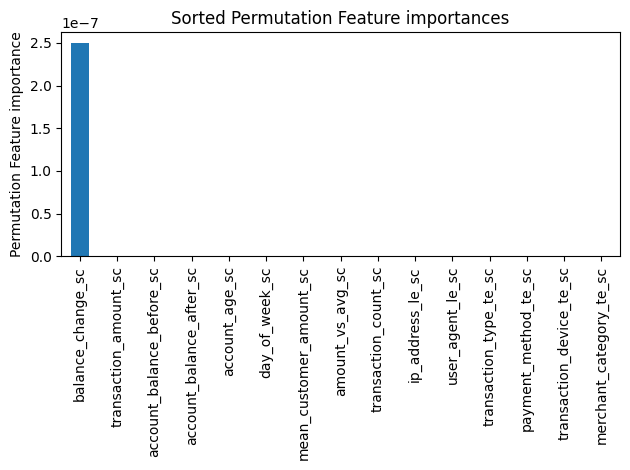

In [66]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=20, random_state=42, n_jobs=8)

feature_names = X_test.columns
tree_importances = pd.Series(result.importances_mean, index=feature_names)
tree_importances = tree_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Sorted Permutation Feature importances")
ax.set_ylabel("Permutation Feature importance")
fig.tight_layout()

- Permutation importance yield zero importances for several reasons, including when a feature is not predictive, when the model is already very strong on the training data, or when correlated features mask the importance of individual features. 

- I think the reason why permutation importance yield zero importances in this case is becasue the model achieves perfect or near-perfect performance on the training data, even permuting important features might not lead to a noticeable drop in performance. When the model is already very accurate on the training data (e.g., score close to 1), shuffling a feature might not cause a noticeable drop in performance, resulting in zero importance.

Random Forests built-in feature importance metrics that can be used as an alternative to permutation importance. 

- Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Text(0.5, 1.0, 'Feature Importances')

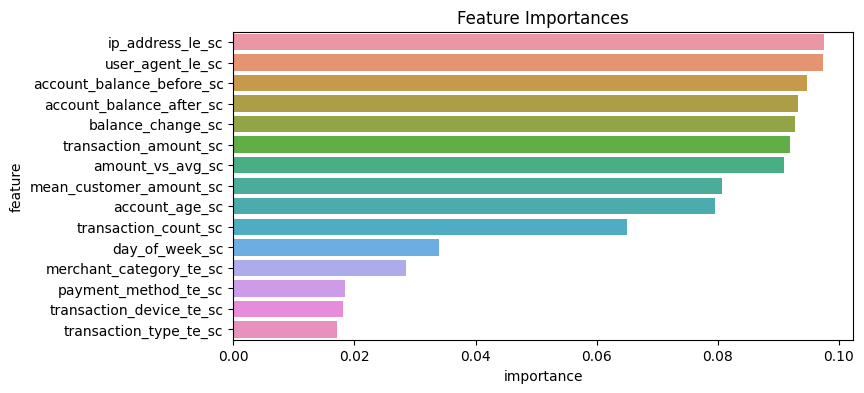

In [67]:
# Get feature importance
importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': rfc.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 4))
sns.barplot(data=importance, x='importance', y='feature')
plt.title('Feature Importances')

- IP Address and User Agent are the most important feature. However, limitations of impurity-based feature importances are biased towards high cardinality features.

- Permutation feature importance overcomes limitations of the impurity-based feature importance as they don't have a bias toward high-cardinality features and can be computed on a left-out test set.

In [68]:
least_importance_features = importance['feature'].tail(3)
print("Least Importance Features:\n", least_importance_features)

Least Importance Features:
 12        payment_method_te_sc
13    transaction_device_te_sc
11      transaction_type_te_sc
Name: feature, dtype: object


- I'll remove 3 features that have lowest level of importance value as they're contributes the least to a model's predictive accuracy or performance.

- Identifying and removing these features can simplify models, improve efficiency, and potentially enhance performance by reducing overfitting.

In [69]:
X_train = X_train.drop(columns=least_importance_features)

X_test = X_test.drop(columns=least_importance_features)

print("Number of Model Features: ", X_train.shape[1])

Number of Model Features:  12


- Perform split of the Training dataset to Train and Validation.

- I'll use Validation dataset to find best performing model using F1 Metric.

In [70]:
X_tr = X_train.copy()
y_tr = y_train.copy()

X_tst = X_test.copy()
y_tst = y_test.copy()

# Split the data into train and test
X_tr, X_valid, y_tr, y_valid = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

In [71]:
print("Train Dimensions:",X_tr.shape)
print("Valid Dimensions:",X_valid.shape)
print("Test Dimensions:",X_tst.shape)

Train Dimensions: (640000, 12)
Valid Dimensions: (160000, 12)
Test Dimensions: (200000, 12)


#### Random Forest

- Once optimal hyper-parameters are found, train model on the Training and evaluate on the Test dataset.  

- I'll evaluate model performance on the Test only once, after the optimal hyper-parameters are found.

- **Note**: Depending on the PC resources, increase speed of model training by specifying `n_jobs` parameter.

In [72]:
best_f1 = 0
best_params = {}
label_col = 'is_fraud'

for n_estimators in [50,100]:
    for max_depth in [5,7,10]:
        for max_features in ['sqrt',5]:
            for max_samples in [0.2,0.4]:
                rfc = RandomForestClassifier(n_jobs=8,
                                             random_state=0, 
                                             bootstrap=True,
                                             n_estimators=n_estimators,
                                             max_depth=max_depth,
                                             max_features=max_features,
                                             max_samples=max_samples)

                rfc.fit(X_tr, y_tr)
                y_valid_pred = rfc.predict(X_valid)
                f1 = f1_score(y_valid, y_valid_pred, average='weighted')
                if f1 > best_f1:
                    best_f1 = f1
                    best_params["n_estimators"] = n_estimators
                    best_params["max_depth"] = max_depth
                    best_params["max_features"] = max_features
                    best_params["max_samples"] = max_samples
                    print("Better Model found. Trained Random Forest With (n_estimators, max_depth, max_features, max_samples):(", \
                                    n_estimators, max_depth,max_features,max_samples,")")
                    print("F1 for Validation:", f1)

Better Model found. Trained Random Forest With (n_estimators, max_depth, max_features, max_samples):( 50 5 sqrt 0.2 )
F1 for Validation: 0.9246922304879496


In [73]:
# Optimal hyper-parameters
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.2}


In [74]:
# Re-train model with best parameters
best_rfc_model = RandomForestClassifier(n_jobs=8,
                                    random_state=0,
                                    bootstrap=True,
                                    n_estimators=best_params["n_estimators"],
                                    max_depth=best_params["max_depth"],
                                    max_features=best_params["max_features"],
                                    max_samples=best_params["max_samples"])

best_rfc_model.fit(X_train, y_train)

# Make predictions
best_model_pred = best_rfc_model.predict(X_test)

print("Trained Random Forest With  Best Parameters:")
print(best_params)

Trained Random Forest With  Best Parameters:
{'n_estimators': 50, 'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.2}


In [75]:
test_predictions = best_rfc_model.predict(X_test)
print("Number Of Predictions:", len(test_predictions))
print("First 20 Predictions:", test_predictions[0:20])

Number Of Predictions: 200000
First 20 Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [76]:
# Performance metrics
print("Optimal Model Accuracy On Training: {:.3f}".format(best_rfc_model.score(X_train, y_train)))
print("Optimal Model Accuracy On Test: {:.3f}\n".format(best_rfc_model.score(X_test, y_test)))

# Performance metrics
print("F1 Score On Test:", f1_score(y_test, best_model_pred, average='weighted'))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_model_pred))

# Performance metrics
print("\nOptimal Model Classification Report:")
print(classification_report(y_test, best_model_pred))

# Area under the precision - recall 
print("\nAUCPR:",average_precision_score(y_true=y_test, y_score=best_rfc_model.predict_proba(X_test)[:,1]))

Optimal Model Accuracy On Training: 0.950
Optimal Model Accuracy On Test: 0.950

F1 Score On Test: 0.9255673248032001

Confusion Matrix:
[[189990      0]
 [ 10010      0]]

Optimal Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    189990
           1       0.00      0.00      0.00     10010

    accuracy                           0.95    200000
   macro avg       0.47      0.50      0.49    200000
weighted avg       0.90      0.95      0.93    200000


AUCPR: 0.050872558934156924


- A low PR-AUC (close to 0) suggests room for improvement in the model's ability to distinguish between positive and negative instances. 

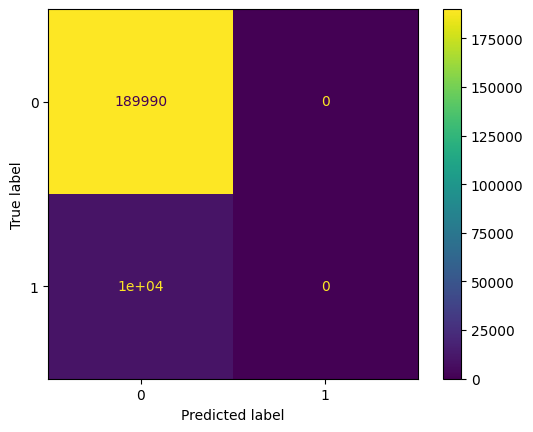

In [77]:
cm = confusion_matrix(y_test, best_model_pred, labels=best_rfc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_rfc_model.classes_)
disp.plot()
plt.show()

- TP: 189,990 samples is the total counts having both predict and actual values are **0 (Not Fraud)**
- TN: 0 samples is the total counts having both predicted and actual values are **1 (Fraud)**

- FP: 10,010 samples is the total counts having prediction is **0 (Not Fraud)** while actually is **1 (Fraud)**
- FN: 0 samples is the total counts having prediction is **1 (Fraud)** while actually is **0 (Not Fraud)**

Text(0.5, 1.0, 'Feature Importances')

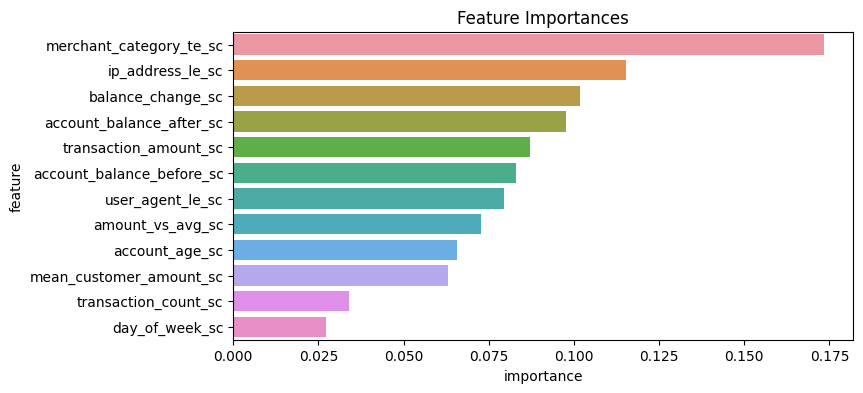

In [80]:
# Get feature importance
best_model_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': best_rfc_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=best_model_importance, x='importance', y='feature')
plt.title('Feature Importances')

In [79]:
print("5 Most Important Features:")
print(best_model_importance.head())

5 Most Important Features:
                     feature  importance
11   merchant_category_te_sc    0.173346
9           ip_address_le_sc    0.115221
8          balance_change_sc    0.101927
2   account_balance_after_sc    0.097812
0      transaction_amount_sc    0.087096


### Summary

- I got no improvement in Accuracy, F1 Score, and AUC PR on Testing dataset after model tuning.

- There's a difference in importance values of features. Merchant Category, Account Balance After, Balance Change, Transaction Amount and IP Address are the 5 most important features. But the importance value of Merchant Category is almost two times higher than the second highest feature and the other 3 features.

- IP Address, Balance Change, and Account Balance After are still in the top 5 most important features even after model tuning. Moreover, Account Balance Before is replaced by Transaction Amount while Merchant Category is moving from the bottom to the top of the list. 

- It also indicates that IP Address, Balance Change and Account Balance After are very important to the model.

---